# THINGS images - Exploring with CLIP

THINGS-images is a freely available database of 26,107 high quality, manually-curated images of 1,854 diverse object concepts, curated systematically from the everyday American English language and using a large-scale web search. Includes 27 high-level categories, semantic embeddings for all concepts, and more metadata.

There's a lot of interesting datasets that have been released based on this one, you can find them here:  
https://things-initiative.org/

You can explore all the categories and selectively download images you want here:
https://things-initiative.org/projects/things-images/

You're going to be using CLIP to explore this dataset, and hopefully discover some cool things about CLIP along the way.

In [2]:
import os

In [3]:
rabbit_images = [x for x in os.listdir('rabbit_images/') if x.endswith('.jpg')]
duck_images = [x for x in os.listdir('duck_images/') if x.endswith('.jpg')]
all_images = rabbit_images + duck_images
categories = set(["rabbit", "duck"])
category2images = {category : [] for category in categories}
for img in rabbit_images:
    category2images['rabbit'].append(img)
for img in duck_images:
    category2images['duck'].append(img)

In [4]:
all_images

['Rabbit_16.jpg',
 'Rabbit_17.jpg',
 'Rabbit_15.jpg',
 'Rabbit_29.jpg',
 'Rabbit_28.jpg',
 'Rabbit_14.jpg',
 'Rabbit_10.jpg',
 'Rabbit_11.jpg',
 'Rabbit_13.jpg',
 'Rabbit_12.jpg',
 'Rabbit_6.jpg',
 'Rabbit_7.jpg',
 'Rabbit_5.jpg',
 'Rabbit_4.jpg',
 'Rabbit_0.jpg',
 'Rabbit_1.jpg',
 'Rabbit_3.jpg',
 'Rabbit_2.jpg',
 'Rabbit_9.jpg',
 'Rabbit_8.jpg',
 'Rabbit_23.jpg',
 'Rabbit_37.jpg',
 'Rabbit_36.jpg',
 'Rabbit_22.jpg',
 'Rabbit_34.jpg',
 'Rabbit_20.jpg',
 'Rabbit_21.jpg',
 'Rabbit_35.jpg',
 'Rabbit_19.jpg',
 'Rabbit_31.jpg',
 'Rabbit_25.jpg',
 'Rabbit_24.jpg',
 'Rabbit_30.jpg',
 'Rabbit_18.jpg',
 'Rabbit_26.jpg',
 'Rabbit_32.jpg',
 'Rabbit_33.jpg',
 'Rabbit_27.jpg',
 'Duck_12.jpg',
 'Duck_13.jpg',
 'Duck_11.jpg',
 'Duck_10.jpg',
 'Duck_14.jpg',
 'Duck_28.jpg',
 'Duck_29.jpg',
 'Duck_15.jpg',
 'Duck_17.jpg',
 'Duck_16.jpg',
 'Duck_8.jpg',
 'Duck_9.jpg',
 'Duck_1.jpg',
 'Duck_0.jpg',
 'Duck_2.jpg',
 'Duck_3.jpg',
 'Duck_7.jpg',
 'Duck_6.jpg',
 'Duck_4.jpg',
 'Duck_5.jpg',
 'Duck_33.jpg',


In [5]:
categories

{'duck', 'rabbit'}

In [6]:
category2images['rabbit']

['Rabbit_16.jpg',
 'Rabbit_17.jpg',
 'Rabbit_15.jpg',
 'Rabbit_29.jpg',
 'Rabbit_28.jpg',
 'Rabbit_14.jpg',
 'Rabbit_10.jpg',
 'Rabbit_11.jpg',
 'Rabbit_13.jpg',
 'Rabbit_12.jpg',
 'Rabbit_6.jpg',
 'Rabbit_7.jpg',
 'Rabbit_5.jpg',
 'Rabbit_4.jpg',
 'Rabbit_0.jpg',
 'Rabbit_1.jpg',
 'Rabbit_3.jpg',
 'Rabbit_2.jpg',
 'Rabbit_9.jpg',
 'Rabbit_8.jpg',
 'Rabbit_23.jpg',
 'Rabbit_37.jpg',
 'Rabbit_36.jpg',
 'Rabbit_22.jpg',
 'Rabbit_34.jpg',
 'Rabbit_20.jpg',
 'Rabbit_21.jpg',
 'Rabbit_35.jpg',
 'Rabbit_19.jpg',
 'Rabbit_31.jpg',
 'Rabbit_25.jpg',
 'Rabbit_24.jpg',
 'Rabbit_30.jpg',
 'Rabbit_18.jpg',
 'Rabbit_26.jpg',
 'Rabbit_32.jpg',
 'Rabbit_33.jpg',
 'Rabbit_27.jpg']

## Note
Turns out the text encoder bundled with the stable-diffusion-2-1-unclip doesn't project to the same image space.
So we're pulling the openCLIP text encoder from the official source, since the unCLIP vision encoder is the exact analogue from openCLIP.

In [9]:
#!pip install torch
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

In [10]:
# !pip install --upgrade diffusers[torch]
# !pip install transformers

In [11]:
#!pip install diffusers
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

/Users/keshav/Documents/COGS118B_Final Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/keshav/Documents/COGS118B_Final Project/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#!pip install accelerate

In [14]:
# ──────────────────────────────────────────────────────────────
# 1.  Load unCLIP – vision side only (projection_dim = 1024)   ─
# ──────────────────────────────────────────────────────────────
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
).to(device)

vision_encoder = pipe.image_encoder                       # keep as-is (1024-d)

Loading pipeline components...: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fai

In [16]:
# ──────────────────────────────────────────────────────────────
# 2.  Swap in an OpenCLIP ViT-H/14 text branch (also 1024-d)  ─
# ──────────────────────────────────────────────────────────────
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [17]:
# ──────────────────────────────────────────────────────────────
# 3. Helpers
# ──────────────────────────────────────────────────────────────
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

def embed_texts(prompts, batch_size=64):
    """Return (N,1024) text embeddings"""
    vecs = []
    for i in range(0, len(prompts), batch_size):
        toks = tokenizer(prompts[i:i + batch_size],
                         padding=True, truncation=True, max_length=77,
                         return_tensors="pt").to(text_encoder.device)
        with torch.no_grad():
            t = text_encoder(**toks).text_embeds        # (B,1024)
        vecs.append(t)
    return torch.cat(vecs)  # (N,1024)


In [18]:
# ──────────────────────────────────────────────────────────────
# 4.  Sanity check on image-text similarity
# ──────────────────────────────────────────────────────────────
img_vec = embed_images(["./duck_images/Duck_22.jpg"])
txt_vec = embed_texts(["duck"])
print("cosine(duck image, \"duck\") →",
      (torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(txt_vec, dim=-1).T).item())

img_vec = embed_images(["./rabbit_images/Rabbit_9.jpg"])
txt_vec = embed_texts(["rabbit"])
print("cosine(rabbit image, \"rabbit\") →",
      (torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(txt_vec, dim=-1).T).item())
# expect ≳ 0.3

cosine(duck image, "duck") → 0.263671875
cosine(rabbit image, "rabbit") → 0.309814453125


In [19]:
# ──────────────────────────────────────────────────────────────
# 5.  Sanity check on image-image similarity
# ──────────────────────────────────────────────────────────────
img_vec = embed_images(["./duck_images/Duck_0.jpg",
                       "./rabbit_images/Rabbit_0.jpg"])
img_vec2 = embed_images(["./duck_images/Duck_1.jpg",
                       "./rabbit_images/Rabbit_1.jpg"])

sims = torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(img_vec2, dim=-1).T
sims = sims.detach().cpu().numpy()

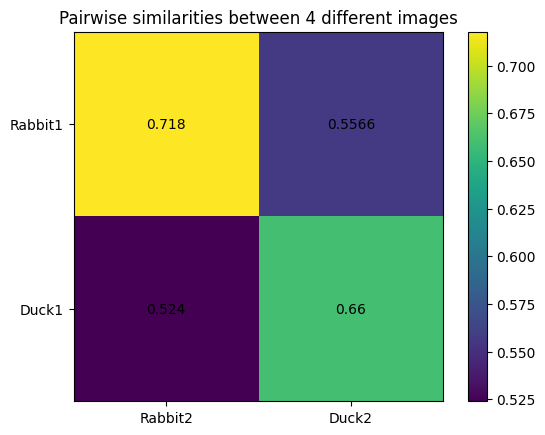

In [20]:
fig, ax = plt.subplots()

# Display the data as an image (heatmap)
im = ax.imshow(sims, cmap='viridis')

# Loop over the data and place text annotations
for i in range(sims.shape[0]):
    for j in range(sims.shape[1]):
        ax.text(j, i, sims[i, j], ha='center', va='center', color='black')

# Add a colorbar for reference
plt.colorbar(im)
plt.yticks([0, 1], ['Rabbit1', 'Duck1'])
plt.xticks([0, 1], ['Rabbit2', 'Duck2'])

# Set title and display the plot
ax.set_title('Pairwise similarities between 4 different images')
plt.show()

# A quick exercise, can you build a classifier using the concepts demonstrated above?

In [21]:
# Here are a few test images, and I can tell you they're either a cat or a mango. Write a classifier function that can predict which one each image is.
os.listdir('test_cases/')

['base_cases', 'illusion_rotation', 'illusion_reallignment']

In [22]:
def classify(pipe, image):
    # write your classification code here, ideally using CLIP

    img_vec = embed_images(["test_cases/" + image])
    text_vec = embed_texts(["rabbit", "duck"])
    sims = torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(text_vec, dim=-1).T
    print(sims)
    return "rabbit" if sims[0][0] > sims[0][1] else "duck"

for img in os.listdir('./test_cases/base_cases/'):
    print(f"{img}: {classify(pipe, 'base_cases/' + img)}")

tensor([[0.1283, 0.2920]], dtype=torch.float16)
Duck_39.jpg: duck
tensor([[0.1528, 0.2927]], dtype=torch.float16)
Duck_38.jpg: duck
tensor([[0.3035, 0.1964]], dtype=torch.float16)
Rabbit_38.jpg: rabbit
tensor([[0.3093, 0.1628]], dtype=torch.float16)
Rabbit_39.jpg: rabbit
tensor([[0.2825, 0.2607]], dtype=torch.float16)
duck-rabbit.jpeg: rabbit


# Illusion Reallignment

In [ ]:
## Only need to uncomment if illusion_reallignment images need to be generated again

# img = Image.open('test_cases/base_cases/duck-rabbit.jpeg')
# width, height = img.size
# original_size = img.size

# # crops (left, right, uppper, lower)
# crops = {
#     'left_three_quarters': (0, 0, int(width * 0.75), height),
#     'left_half': (0, 0, int(width * 0.5), height),
#     'right_three_quarters': (int(width * 0.25), 0, width, height),
#     'right_half': (int(width * 0.5), 0, width, height),
#     'upper_half': (0, 0, width, int(height * 0.5)),
#     'bottom_half': (0, int(height * 0.5), width, height),
# }

# base_name = "illusion"
# for crop_name, crop_box in crops.items():
#     cropped = img.crop(crop_box)
#     file_name = f"{base_name}_{crop_name}.jpg"
#     cropped.save('./test_cases/illusion_reallignment/' + file_name)


In [ ]:
for img in os.listdir('./test_cases/illusion_reallignment/'):
    print(f"{img}: {classify(pipe, 'illusion_reallignment/' + img)}")


tensor([[0.1093, 0.1541]], dtype=torch.float16)
illusion_bottom_half.jpg: duck
tensor([[0.1635, 0.1835]], dtype=torch.float16)
illusion_left_half.jpg: duck
tensor([[0.2849, 0.2155]], dtype=torch.float16)
illusion_right_half.jpg: rabbit
tensor([[0.2218, 0.2769]], dtype=torch.float16)
illusion_left_three_quarters.jpg: duck
tensor([[0.1741, 0.2109]], dtype=torch.float16)
illusion_upper_half.jpg: duck
tensor([[0.2976, 0.2532]], dtype=torch.float16)
illusion_right_three_quarters.jpg: rabbit


# Illusion Rotation

In [ ]:
## Only need to uncomment if illusion_rotation images need to be generated again

# img = Image.open('test_cases/base_cases/duck-rabbit.jpeg')
# width, height = img.size
# original_size = img.size

# # crops (left, right, uppper, lower)
# rotations = {
#         'rot_neg30deg': -30,
#         'rot_neg45deg': -45,
#         'rot_neg60deg': -60,
#         'rot_neg90deg': -90,
#         'rot_pos30deg': 30,
#         'rot_pos45deg': 45,
#         'rot_pos60deg': 60,
#         'rot_pos90deg': 90,
#         'rot_pos180deg': 180,
#     }

# base_name = "illusion"
# for rotation_name, rotation_angle in rotations.items():
#     rotated = img.rotate(rotation_angle, expand=True)
#     file_name = f"{base_name}_{rotation_name}.jpg"
#     rotated.save('./test_cases/illusion_rotation/' + file_name)

In [ ]:
for img in os.listdir('./test_cases/illusion_rotation/'):
    print(f"{img}: {classify(pipe, 'illusion_rotation/' + img)}")

tensor([[0.3389, 0.2084]], dtype=torch.float16)
illusion_rot_neg45deg.jpg: rabbit
tensor([[0.3181, 0.1788]], dtype=torch.float16)
illusion_rot_neg90deg.jpg: rabbit
tensor([[0.2886, 0.2832]], dtype=torch.float16)
illusion_rot_pos30deg.jpg: rabbit
tensor([[0.2944, 0.2849]], dtype=torch.float16)
illusion_rot_pos45deg.jpg: rabbit
tensor([[0.3352, 0.2085]], dtype=torch.float16)
illusion_rot_neg30deg.jpg: rabbit
tensor([[0.2847, 0.2433]], dtype=torch.float16)
illusion_rot_pos90deg.jpg: rabbit
tensor([[0.3320, 0.1981]], dtype=torch.float16)
illusion_rot_neg60deg.jpg: rabbit
tensor([[0.2737, 0.2510]], dtype=torch.float16)
illusion_rot_pos180deg.jpg: rabbit
tensor([[0.2800, 0.2698]], dtype=torch.float16)
illusion_rot_pos60deg.jpg: rabbit


# Illusion Colorization


In [44]:
## Only need to uncomment if illusion_colorization images need to be generated again

img = Image.open('test_cases/base_cases/duck-rabbit.jpeg')
width, height = img.size
img_array = np.array(img)

# colors (red, blue, green)
colors = {
    'red': (255, 100, 100),
    'blue': (100, 100, 255),
    'green': (100, 255, 100),
}

# regions (left, right, top, bottom, three-fourths)
regions = {
    'left_half': (slice(None), slice(0, width // 2)),
    'right_half': (slice(None), slice(width // 2, None)),
    'top_half': (slice(0, height // 2), slice(None)),
    'bottom_half': (slice(height // 2, None), slice(None)),
    'left_three_fourths': (slice(None), slice(0, int(width * 0.75))),
    'right_three_fourths': (slice(None), slice(int(width * 0.25), None)),
}

os.makedirs('./test_cases/illusion_colorization/', exist_ok=True)

base_name = "illusion"
alpha = 0.4

# region overlays
for color_name, color_rgb in colors.items():
    for region_name, (r, c) in regions.items():
        tinted = img_array.copy()
        region = tinted[r, c]
        blended = (1 - alpha) * region + alpha * np.array(color_rgb)
        tinted[r, c] = blended.astype(np.uint8)

        out = Image.fromarray(tinted)
        file_name = f"{base_name}_{region_name}_{color_name}.jpg"
        out.save('./test_cases/illusion_colorization/' + file_name)

# full tints
for tint_name, tint_rgb in colors.items():
    overlay = Image.new('RGB', (width, height), tint_rgb)
    blended = Image.blend(Image.fromarray(img_array), overlay, 0.3)
    file_name = f"{base_name}_{tint_name}.jpg"
    blended.save('./test_cases/illusion_colorization/' + file_name)

In [45]:
for img in os.listdir('./test_cases/illusion_colorization/'):
    print(f"{img}: {classify(pipe, 'illusion_colorization/' + img)}")


tensor([[0.2365, 0.2549]], dtype=torch.float16)
illusion_top_half_green.jpg: duck
tensor([[0.2625, 0.2496]], dtype=torch.float16)
real_rabbit_color.jpg: rabbit
tensor([[0.2325, 0.2612]], dtype=torch.float16)
illusion_left_three_fourths_green.jpg: duck
tensor([[0.2698, 0.2416]], dtype=torch.float16)
illusion_left_half_blue.jpg: rabbit
tensor([[0.2544, 0.2446]], dtype=torch.float16)
illusion_top_half_red.jpg: rabbit
tensor([[0.2307, 0.2542]], dtype=torch.float16)
illusion_left_three_fourths_red.jpg: duck
tensor([[0.2588, 0.2463]], dtype=torch.float16)
illusion_bottom_half_green.jpg: rabbit
tensor([[0.2439, 0.2438]], dtype=torch.float16)
illusion_right_half_blue.jpg: rabbit
tensor([[0.2277, 0.2681]], dtype=torch.float16)
illusion_right_three_fourths_blue.jpg: duck
tensor([[0.2751, 0.2286]], dtype=torch.float16)
illusion_left_half_red.jpg: rabbit
tensor([[0.2301, 0.2517]], dtype=torch.float16)
illusion_right_three_fourths_red.jpg: duck
tensor([[0.2480, 0.2367]], dtype=torch.float16)
illusi